## Fourth model

In [1]:
import os
import re
import ast
import typing
import requests
import icalendar
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import date, datetime
from icalendar import Calendar, Event, vCalAddress, vText

import xgboost as xgb
from xgboost import plot_importance

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

%matplotlib inline

np.random.seed(31415)

sns.set(rc={'figure.figsize':(15,3)})
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
df = pd.read_csv('all_mean_hour_ctx_2.csv')
df.head()

,station_id,year,month,day,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4
0,1.0,2020.0,1.0,1.0,4.0,0.364815,0.283333,0.346296,0.394444,0.459259
1,1.0,2020.0,1.0,1.0,9.0,0.262963,0.248148,0.235185,0.233333,0.298148
2,1.0,2020.0,1.0,1.0,14.0,0.335185,0.381481,0.385185,0.337037,0.342593
3,1.0,2020.0,1.0,1.0,19.0,0.209259,0.079630,0.177778,0.211111,0.244444
4,1.0,2020.0,1.0,2.0,0.0,0.387037,0.420370,0.450000,0.492593,0.418519


In [3]:
df.shape

(2635990, 10)

In [4]:
df.year.unique()

array([2020., 2021., 2022., 2023.])

In [5]:
df.month.unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [6]:
df.station_id.nunique()

399

In [7]:
test = pd.read_csv('metadata_sample_submission_2024.csv')
test.head()

,index,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1
0,0,1,1,1,5,0.781481,0.677778,0.696296,0.750000
1,1,1,1,1,10,0.737374,0.711111,0.711111,0.731624
2,2,1,1,1,15,0.827778,0.896296,0.901852,0.883333
3,3,1,1,1,20,0.825926,0.874074,0.927778,0.918519
4,4,2,1,1,3,0.592593,0.341954,0.275862,0.540230


Let's order the columns like in the test csv file.

In [8]:
# Reorder the columns as specified
new_column_order = ['station_id', 'year', 'month', 'day', 'hour', 
                    'ctx-4', 'ctx-3', 'ctx-2', 'ctx-1', 'percentage_docks_available']

# Apply the new column order
df = df[new_column_order]

# Display the first few rows of the reordered DataFrame
df.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available
0,1.0,2020.0,1.0,1.0,4.0,0.459259,0.394444,0.346296,0.283333,0.364815
1,1.0,2020.0,1.0,1.0,9.0,0.298148,0.233333,0.235185,0.248148,0.262963
2,1.0,2020.0,1.0,1.0,14.0,0.342593,0.337037,0.385185,0.381481,0.335185
3,1.0,2020.0,1.0,1.0,19.0,0.244444,0.211111,0.177778,0.079630,0.209259
4,1.0,2020.0,1.0,2.0,0.0,0.418519,0.492593,0.450000,0.420370,0.387037


### Train, Validation and Test

Now let's split our datafram (df) into train and validation datasets. The test dataframe is the one provided in Kaggle.

In [9]:
# FUNCTION TO SPLIT TRAIN AND VALIDATION 80/20
def train_validation_split(df):
    # Order by time (Year, Month, Day, Hour, station_id) -- THIS STEP IS VERY IMPORTANT
    df_to_split = df.sort_values(by=['year', 'month', 'day', 'hour', 'station_id']).reset_index(drop=True)
    # Calculate the index that divide the dataframe by 80/20
    train_size = int(len(df_to_split) * 0.8)
    # Create column named "index"
    df_to_split['index'] = df_to_split.index
    # Get train and validation dataframes
    train = df_to_split.iloc[:train_size]
    validation = df_to_split.iloc[train_size:]
    
    # Reorder again by station_id first
    train = train.sort_values(by=['station_id','year', 'month', 'day', 'hour']).reset_index(drop=True)
    validation = validation.sort_values(by=['station_id','year', 'month', 'day', 'hour']).reset_index(drop=True)

    return train, validation

In [10]:
train, validation = train_validation_split(df)

In [11]:
train.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index
0,1.0,2020.0,1.0,1.0,4.0,0.459259,0.394444,0.346296,0.283333,0.364815,0
1,1.0,2020.0,1.0,1.0,9.0,0.298148,0.233333,0.235185,0.248148,0.262963,394
2,1.0,2020.0,1.0,1.0,14.0,0.342593,0.337037,0.385185,0.381481,0.335185,788
3,1.0,2020.0,1.0,1.0,19.0,0.244444,0.211111,0.177778,0.079630,0.209259,1182
4,1.0,2020.0,1.0,2.0,0.0,0.418519,0.492593,0.450000,0.420370,0.387037,1576


In [12]:
train.shape

(2108792, 11)

In [13]:
validation.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index
0,1.0,2023.0,3.0,6.0,23.0,0.487037,0.472222,0.429630,0.374074,0.285185,2109039
1,1.0,2023.0,3.0,7.0,4.0,0.172222,0.155556,0.155556,0.155556,0.198148,2109437
2,1.0,2023.0,3.0,7.0,9.0,0.207407,0.337037,0.618519,0.990741,0.950000,2109835
3,1.0,2023.0,3.0,7.0,14.0,0.948148,0.946296,0.935185,0.914815,0.790741,2110233
4,1.0,2023.0,3.0,7.0,19.0,0.709259,0.631481,0.527778,0.483333,0.353704,2110630


In [14]:
validation.shape

(527198, 11)

### Adding info from the dataset info_bike_stations

In [15]:
df_info = pd.read_csv('Informacio_Estacions_Bicing.csv')
df_info.head()

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,is_charging_station,nearby_distance,_ride_code_support,rental_uris,cross_street
0,1,"GRAN VIA CORTS CATALANES, 760",ELECTRICBIKESTATION,41.397978,2.180107,16.0,"GRAN VIA CORTS CATALANES, 760",8013,45,True,1000.0,True,NaN,NaN
1,2,"C/ ROGER DE FLOR, 126",ELECTRICBIKESTATION,41.395488,2.177198,17.0,"C/ ROGER DE FLOR, 126",8013,29,True,1000.0,True,NaN,NaN
2,3,"C/ NÀPOLS, 82",ELECTRICBIKESTATION,41.394156,2.181331,11.0,"C/ NÀPOLS, 82",8013,27,True,1000.0,True,NaN,NaN
3,4,"C/ RIBES, 13",ELECTRICBIKESTATION,41.393317,2.181248,8.0,"C/ RIBES, 13",8013,21,True,1000.0,True,NaN,NaN
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",ELECTRICBIKESTATION,41.391103,2.180176,7.0,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",8018,39,True,1000.0,True,NaN,NaN


In [16]:
# Select the variables I want to add
station_var = ['station_id', 'lat', 'lon', 'altitude', 'capacity']

In [17]:
df_info = df_info[station_var]
df_info.head()

,station_id,lat,lon,altitude,capacity
0,1,41.397978,2.180107,16.0,45
1,2,41.395488,2.177198,17.0,29
2,3,41.394156,2.181331,11.0,27
3,4,41.393317,2.181248,8.0,21
4,5,41.391103,2.180176,7.0,39


In [18]:
df_info['station_id'] = df_info['station_id'].astype(float)
df_info.head()

,station_id,lat,lon,altitude,capacity
0,1.0,41.397978,2.180107,16.0,45
1,2.0,41.395488,2.177198,17.0,29
2,3.0,41.394156,2.181331,11.0,27
3,4.0,41.393317,2.181248,8.0,21
4,5.0,41.391103,2.180176,7.0,39


In [19]:
train = pd.merge(train, df_info, how='left')
validation = pd.merge(validation, df_info, how='left')
test = pd.merge(test, df_info, how='left')

In [20]:
train.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index,lat,lon,altitude,capacity
0,1.0,2020.0,1.0,1.0,4.0,0.459259,0.394444,0.346296,0.283333,0.364815,0,41.397978,2.180107,16.0,45
1,1.0,2020.0,1.0,1.0,9.0,0.298148,0.233333,0.235185,0.248148,0.262963,394,41.397978,2.180107,16.0,45
2,1.0,2020.0,1.0,1.0,14.0,0.342593,0.337037,0.385185,0.381481,0.335185,788,41.397978,2.180107,16.0,45
3,1.0,2020.0,1.0,1.0,19.0,0.244444,0.211111,0.177778,0.079630,0.209259,1182,41.397978,2.180107,16.0,45
4,1.0,2020.0,1.0,2.0,0.0,0.418519,0.492593,0.450000,0.420370,0.387037,1576,41.397978,2.180107,16.0,45


In [21]:
train.shape

(2108792, 15)

In [22]:
validation.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index,lat,lon,altitude,capacity
0,1.0,2023.0,3.0,6.0,23.0,0.487037,0.472222,0.429630,0.374074,0.285185,2109039,41.397978,2.180107,16.0,45
1,1.0,2023.0,3.0,7.0,4.0,0.172222,0.155556,0.155556,0.155556,0.198148,2109437,41.397978,2.180107,16.0,45
2,1.0,2023.0,3.0,7.0,9.0,0.207407,0.337037,0.618519,0.990741,0.950000,2109835,41.397978,2.180107,16.0,45
3,1.0,2023.0,3.0,7.0,14.0,0.948148,0.946296,0.935185,0.914815,0.790741,2110233,41.397978,2.180107,16.0,45
4,1.0,2023.0,3.0,7.0,19.0,0.709259,0.631481,0.527778,0.483333,0.353704,2110630,41.397978,2.180107,16.0,45


In [23]:
validation.shape

(527198, 15)

In [24]:
test.head()

,index,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,capacity
0,0,1,1,1,5,0.781481,0.677778,0.696296,0.750000,41.397978,2.180107,16.0,45
1,1,1,1,1,10,0.737374,0.711111,0.711111,0.731624,41.397978,2.180107,16.0,45
2,2,1,1,1,15,0.827778,0.896296,0.901852,0.883333,41.397978,2.180107,16.0,45
3,3,1,1,1,20,0.825926,0.874074,0.927778,0.918519,41.397978,2.180107,16.0,45
4,4,2,1,1,3,0.592593,0.341954,0.275862,0.540230,41.395488,2.177198,17.0,29


In [25]:
test.shape

(171902, 13)

### Transforming Time data and adding new features

#### Adding datetime column

In [26]:
# Adding the column year
test['year'] = 2024.0

In [27]:
# Combine year, month, day and hour into a single datetime column
train['datetime'] = pd.to_datetime(train[['year', 'month', 'day', 'hour']])
validation['datetime'] = pd.to_datetime(validation[['year', 'month', 'day', 'hour']])
test['datetime'] = pd.to_datetime(test[['year', 'month', 'day', 'hour']])

In [28]:
train.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index,lat,lon,altitude,capacity,datetime
0,1.0,2020.0,1.0,1.0,4.0,0.459259,0.394444,0.346296,0.283333,0.364815,0,41.397978,2.180107,16.0,45,2020-01-01 04:00:00
1,1.0,2020.0,1.0,1.0,9.0,0.298148,0.233333,0.235185,0.248148,0.262963,394,41.397978,2.180107,16.0,45,2020-01-01 09:00:00
2,1.0,2020.0,1.0,1.0,14.0,0.342593,0.337037,0.385185,0.381481,0.335185,788,41.397978,2.180107,16.0,45,2020-01-01 14:00:00
3,1.0,2020.0,1.0,1.0,19.0,0.244444,0.211111,0.177778,0.079630,0.209259,1182,41.397978,2.180107,16.0,45,2020-01-01 19:00:00
4,1.0,2020.0,1.0,2.0,0.0,0.418519,0.492593,0.450000,0.420370,0.387037,1576,41.397978,2.180107,16.0,45,2020-01-02 00:00:00


In [29]:
# We're going to add extra features regarding the day, the hour and the seaon (month)
datetime_features = ['day_info', 'hour_info', 'season_info']

#### Adding extra feature regarding the day

In [30]:
def create_day_info(datetime):
    return 'weekend' if datetime.weekday() in [5, 6] else 'weekday'

In [31]:
train['day_info'] = train.datetime.apply(lambda x: create_day_info(x))
validation['day_info'] = validation.datetime.apply(lambda x: create_day_info(x))
test['day_info'] = test.datetime.apply(lambda x: create_day_info(x))

In [32]:
train.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index,lat,lon,altitude,capacity,datetime,day_info
0,1.0,2020.0,1.0,1.0,4.0,0.459259,0.394444,0.346296,0.283333,0.364815,0,41.397978,2.180107,16.0,45,2020-01-01 04:00:00,weekday
1,1.0,2020.0,1.0,1.0,9.0,0.298148,0.233333,0.235185,0.248148,0.262963,394,41.397978,2.180107,16.0,45,2020-01-01 09:00:00,weekday
2,1.0,2020.0,1.0,1.0,14.0,0.342593,0.337037,0.385185,0.381481,0.335185,788,41.397978,2.180107,16.0,45,2020-01-01 14:00:00,weekday
3,1.0,2020.0,1.0,1.0,19.0,0.244444,0.211111,0.177778,0.079630,0.209259,1182,41.397978,2.180107,16.0,45,2020-01-01 19:00:00,weekday
4,1.0,2020.0,1.0,2.0,0.0,0.418519,0.492593,0.450000,0.420370,0.387037,1576,41.397978,2.180107,16.0,45,2020-01-02 00:00:00,weekday


#### Adding extra feature regarding the hour

In [33]:
def create_hour_info(datetime):
    if datetime.hour in (0, 1, 2, 3, 4, 5):
        return 'night'

    elif datetime.hour in (6, 7, 8, 9):
        return 'early_morning'

    elif datetime.hour in (10, 11, 12, 13, 14):
        return 'morning'
    
    elif datetime.hour in (15, 16, 17, 18, 19):
        return 'afternoon'
    
    elif datetime.hour in (20, 21, 22, 23):
        return 'evening'

In [34]:
train['hour_info'] = train.datetime.apply(lambda x: create_hour_info(x))
validation['hour_info'] = validation.datetime.apply(lambda x: create_hour_info(x))
test['hour_info'] = test.datetime.apply(lambda x: create_hour_info(x))

In [35]:
train.head(2)

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index,lat,lon,altitude,capacity,datetime,day_info,hour_info
0,1.0,2020.0,1.0,1.0,4.0,0.459259,0.394444,0.346296,0.283333,0.364815,0,41.397978,2.180107,16.0,45,2020-01-01 04:00:00,weekday,night
1,1.0,2020.0,1.0,1.0,9.0,0.298148,0.233333,0.235185,0.248148,0.262963,394,41.397978,2.180107,16.0,45,2020-01-01 09:00:00,weekday,early_morning


#### Adding extra feature regarding the season

In [36]:
def create_season_info(datetime):
    if datetime.month in (3, 4, 5):
        return 'spring'
    
    elif datetime.month in (6, 7, 8):
        return 'summer'
    
    elif datetime.month in (9, 10, 11):
        return 'autumn'
    
    elif datetime.month in (12, 1, 2):
        return 'winter'

In [37]:
train['season_info'] = train.datetime.apply(lambda x: create_season_info(x))
validation['season_info'] = validation.datetime.apply(lambda x: create_season_info(x))
test['season_info'] = test.datetime.apply(lambda x: create_season_info(x))

In [38]:
train.head(2)

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index,lat,lon,altitude,capacity,datetime,day_info,hour_info,season_info
0,1.0,2020.0,1.0,1.0,4.0,0.459259,0.394444,0.346296,0.283333,0.364815,0,41.397978,2.180107,16.0,45,2020-01-01 04:00:00,weekday,night,winter
1,1.0,2020.0,1.0,1.0,9.0,0.298148,0.233333,0.235185,0.248148,0.262963,394,41.397978,2.180107,16.0,45,2020-01-01 09:00:00,weekday,early_morning,winter


### OneHotEncoder for categorical variables

In [39]:
# Specify the categorical variables
categorical_vars = ['day_info', 'hour_info', 'season_info']

# Initialize the OneHotEncoder
one_hot_encoder = OneHotEncoder(drop='first')  # drop='first' to avoid multicollinearity

# Fit and transform the training data
train_encoded = one_hot_encoder.fit_transform(train[categorical_vars]).toarray()

# Transform the validation and test data
valid_encoded = one_hot_encoder.transform(validation[categorical_vars]).toarray()
test_encoded = one_hot_encoder.transform(test[categorical_vars]).toarray()

In [40]:
# Get feature names from OneHotEncoder
feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# Convert to DataFrames
train_encoded_df = pd.DataFrame(train_encoded, columns=feature_names, index=train.index)
valid_encoded_df = pd.DataFrame(valid_encoded, columns=feature_names, index=validation.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=feature_names, index=test.index)

# Drop the original categorical columns from the original dataframes
train = train.drop(columns=categorical_vars)
validation = validation.drop(columns=categorical_vars)
test = test.drop(columns=categorical_vars)

# Concatenate the encoded columns back to the original dataframes
train = pd.concat([train, train_encoded_df], axis=1)
validation = pd.concat([validation, valid_encoded_df], axis=1)
test = pd.concat([test, test_encoded_df], axis=1)

In [41]:
train.head(2)

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index,lat,lon,altitude,capacity,datetime,day_info_weekend,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_spring,season_info_summer,season_info_winter
0,1.0,2020.0,1.0,1.0,4.0,0.459259,0.394444,0.346296,0.283333,0.364815,0,41.397978,2.180107,16.0,45,2020-01-01 04:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,2020.0,1.0,1.0,9.0,0.298148,0.233333,0.235185,0.248148,0.262963,394,41.397978,2.180107,16.0,45,2020-01-01 09:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Adding extra feature - Holidays

In [42]:
df_holiday = pd.read_csv('bcn_holidays_2020_2024.csv')
df_holiday.head(10)

,year,month,day
0,2020,1,1
1,2020,1,6
2,2020,4,10
3,2020,4,13
4,2020,5,1
5,2020,5,1
6,2020,6,24
7,2020,8,15
8,2020,9,11
9,2020,9,24


In [43]:
df_holiday.shape

(80, 3)

In [44]:
# Drop duplicate rows
df_holiday = df_holiday.drop_duplicates()

In [45]:
df_holiday.shape

(79, 3)

In [46]:
# Convert all columns to float
df_holiday = df_holiday.astype(float)

In [47]:
df_holiday.head(2)

,year,month,day
0,2020.0,1.0,1.0
1,2020.0,1.0,6.0


In [48]:
# Merge the DataFrames to mark holidays
train['is_holiday'] = 0  # Initialize with 0
merged_df = train.merge(df_holiday, on=['year', 'month', 'day'], how='left', indicator=True)

# Mark holidays as 1
train.loc[merged_df['_merge'] == 'both', 'is_holiday'] = 1

In [49]:
train.head(2)

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index,lat,lon,altitude,capacity,datetime,day_info_weekend,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_spring,season_info_summer,season_info_winter,is_holiday
0,1.0,2020.0,1.0,1.0,4.0,0.459259,0.394444,0.346296,0.283333,0.364815,0,41.397978,2.180107,16.0,45,2020-01-01 04:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,1.0,2020.0,1.0,1.0,9.0,0.298148,0.233333,0.235185,0.248148,0.262963,394,41.397978,2.180107,16.0,45,2020-01-01 09:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [50]:
# Merge the DataFrames to mark holidays
validation['is_holiday'] = 0  # Initialize with 0
merged_df = validation.merge(df_holiday, on=['year', 'month', 'day'], how='left', indicator=True)

# Mark holidays as 1
validation.loc[merged_df['_merge'] == 'both', 'is_holiday'] = 1

In [51]:
validation.tail(2)

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,index,lat,lon,altitude,capacity,datetime,day_info_weekend,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_spring,season_info_summer,season_info_winter,is_holiday
527196,496.0,2023.0,12.0,31.0,17.0,0.879630,0.819444,0.768519,0.699074,0.666667,2635507,41.404862,2.174799,33.0,18,2023-12-31 17:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
527197,496.0,2023.0,12.0,31.0,22.0,0.722222,0.643519,0.736111,0.731481,0.717593,2635905,41.404862,2.174799,33.0,18,2023-12-31 22:00:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [52]:
# Merge the DataFrames to mark holidays
test['is_holiday'] = 0  # Initialize with 0
merged_df = test.merge(df_holiday, on=['year', 'month', 'day'], how='left', indicator=True)

# Mark holidays as 1
test.loc[merged_df['_merge'] == 'both', 'is_holiday'] = 1

In [53]:
test.head()

,index,station_id,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,capacity,year,datetime,day_info_weekend,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_spring,season_info_summer,season_info_winter,is_holiday
0,0,1,1,1,5,0.781481,0.677778,0.696296,0.750000,41.397978,2.180107,16.0,45,2024.0,2024-01-01 05:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,1,1,1,1,10,0.737374,0.711111,0.711111,0.731624,41.397978,2.180107,16.0,45,2024.0,2024-01-01 10:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2,2,1,1,1,15,0.827778,0.896296,0.901852,0.883333,41.397978,2.180107,16.0,45,2024.0,2024-01-01 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,3,1,1,1,20,0.825926,0.874074,0.927778,0.918519,41.397978,2.180107,16.0,45,2024.0,2024-01-01 20:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,4,2,1,1,3,0.592593,0.341954,0.275862,0.540230,41.395488,2.177198,17.0,29,2024.0,2024-01-01 03:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


### Linear Regression Model

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Select features and target
features = ['station_id', 'year', 'month', 'day', 'hour', 'ctx-4', 'ctx-3', 'ctx-2', 'ctx-1', 'lat', 'lon', 'altitude', 'capacity',
           'day_info_weekend', 'hour_info_early_morning', 'hour_info_evening', 'hour_info_morning', 'hour_info_night',
           'season_info_spring', 'season_info_summer', 'season_info_winter', 'is_holiday']
target = 'percentage_docks_available'

# Columns to be scaled
columns_to_scale = ['station_id', 'year', 'month', 'day', 'hour', 'altitude', 'capacity']

X_train = train[features]
y_train = train[target]

X_val = validation[features]
y_val = validation[target]

# Initialize the ColumnTransformer with StandardScaler for specified columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Keep the other columns as they are
)

# Fit and transform on training data
X_train_scaled = preprocessor.fit_transform(X_train)

# Transform validation data (use the same scaler as fitted on training data)
X_val_scaled = preprocessor.transform(X_val)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Predict using the validation set
y_pred = model.predict(X_val_scaled)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Optionally, show the first few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print(comparison.head())

Mean Squared Error: 0.011238997920533652
R^2 Score: 0.8426818167043134
     Actual  Predicted
0  0.285185   0.375752
1  0.198148   0.199830
2  0.950000   1.013097
3  0.790741   0.865228
4  0.353704   0.482324


### First Kaggle submission

In [66]:
# Reorder the test dataframe:
new_column_order = ['index', 'station_id', 'year', 'month', 'day', 'hour', 'ctx-4', 'ctx-3', 'ctx-2', 'ctx-1', 'lat', 'lon', 'altitude', 'capacity',
                    'day_info_weekend', 'hour_info_early_morning', 'hour_info_evening', 'hour_info_morning', 'hour_info_night',
                    'season_info_spring', 'season_info_summer', 'season_info_winter', 'is_holiday']

# Apply the new column order
test = test[new_column_order]

# Display the first few rows of the reordered DataFrame
test.head()

,index,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,capacity,day_info_weekend,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_spring,season_info_summer,season_info_winter,is_holiday
0,0,1,2024.0,1,1,5,0.781481,0.677778,0.696296,0.750000,41.397978,2.180107,16.0,45,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,1,1,2024.0,1,1,10,0.737374,0.711111,0.711111,0.731624,41.397978,2.180107,16.0,45,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2,2,1,2024.0,1,1,15,0.827778,0.896296,0.901852,0.883333,41.397978,2.180107,16.0,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,3,1,2024.0,1,1,20,0.825926,0.874074,0.927778,0.918519,41.397978,2.180107,16.0,45,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,4,2,2024.0,1,1,3,0.592593,0.341954,0.275862,0.540230,41.395488,2.177198,17.0,29,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


In [67]:
# Define the features:
features = ['station_id', 'year', 'month', 'day', 'hour', 'ctx-4', 'ctx-3', 'ctx-2', 'ctx-1', 'lat', 'lon', 'altitude', 'capacity',
           'day_info_weekend', 'hour_info_early_morning', 'hour_info_evening', 'hour_info_morning', 'hour_info_night',
            'season_info_spring', 'season_info_summer', 'season_info_winter', 'is_holiday']

In [68]:
test = test[features]
test.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,capacity,day_info_weekend,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_spring,season_info_summer,season_info_winter,is_holiday
0,1,2024.0,1,1,5,0.781481,0.677778,0.696296,0.750000,41.397978,2.180107,16.0,45,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,1,2024.0,1,1,10,0.737374,0.711111,0.711111,0.731624,41.397978,2.180107,16.0,45,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
2,1,2024.0,1,1,15,0.827778,0.896296,0.901852,0.883333,41.397978,2.180107,16.0,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,1,2024.0,1,1,20,0.825926,0.874074,0.927778,0.918519,41.397978,2.180107,16.0,45,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,2,2024.0,1,1,3,0.592593,0.341954,0.275862,0.540230,41.395488,2.177198,17.0,29,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


In [69]:
# Convert all variables into floats:
test = test.astype(float)

In [70]:
test.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,lat,lon,altitude,capacity,day_info_weekend,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_spring,season_info_summer,season_info_winter,is_holiday
0,1.0,2024.0,1.0,1.0,5.0,0.781481,0.677778,0.696296,0.750000,41.397978,2.180107,16.0,45.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,1.0,2024.0,1.0,1.0,10.0,0.737374,0.711111,0.711111,0.731624,41.397978,2.180107,16.0,45.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,1.0,2024.0,1.0,1.0,15.0,0.827778,0.896296,0.901852,0.883333,41.397978,2.180107,16.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,2024.0,1.0,1.0,20.0,0.825926,0.874074,0.927778,0.918519,41.397978,2.180107,16.0,45.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,2.0,2024.0,1.0,1.0,3.0,0.592593,0.341954,0.275862,0.540230,41.395488,2.177198,17.0,29.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [71]:
# Transform test data (use the same scaler as fitted on training data)
test_scaled = scaler.transform(test)

In [72]:
# Predict using the test set
y_pred_test = model.predict(test_scaled)

In [274]:
df_output = pd.DataFrame(y_pred_test)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']

df_output.to_csv('Submission_7.csv',index=False)

In [275]:
df_output.head()

,index,percentage_docks_available
0,0,0.730434
1,1,0.717361
2,2,0.843211
3,3,0.865135
4,4,0.594304


In [276]:
df_output.shape

(171902, 2)

### XGBOOST model

In [73]:
from numpy import sort

In [74]:
xgb_model = xgb.XGBRFRegressor(
    objective='reg:logistic', 
    eval_metric='rmse', 
) # , n_estimators=200, max_depth=5)

In [75]:
xgb_model.fit(X_train_scaled, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='rmse', feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:logistic',
               random_state=None, reg_alpha=None, ...)

In [76]:
# Predict using the validation set
y_pred_xgb = xgb_model.predict(X_val_scaled)

In [77]:
# Evaluate the model
mse = mean_squared_error(y_val, y_pred_xgb)
r2 = r2_score(y_val, y_pred_xgb)

In [78]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Optionally, show the first few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred_xgb})
print(comparison.head())

Mean Squared Error: 0.012209020207807023
R^2 Score: 0.8291039029909058
     Actual  Predicted
0  0.285185   0.379512
1  0.198148   0.217710
2  0.950000   0.844092
3  0.790741   0.822458
4  0.353704   0.483903


In [79]:
mean_squared_error(y_train, xgb_model.predict(X_train_scaled), squared=False)

0.11420820118671984

In [80]:
P_valid = xgb_model.predict(X_val_scaled)

In [81]:
mean_squared_error(y_val, P_valid, squared=False)

0.11049443518932084

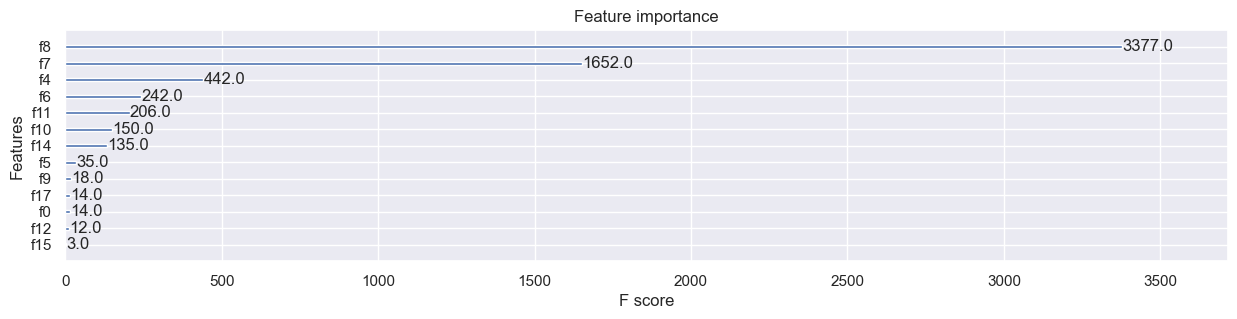

In [82]:
plot_importance(xgb_model)
plt.show()

### Neural Networks

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-06-18 20:01:13.463712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [84]:
# Define the neural network model
model = Sequential()
model.add(Dense(256, input_dim=len(features), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))  # For regression, the output layer should have 1 unit and 'linear' activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=10024, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - loss: 0.0427 - val_loss: 0.0136
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 9/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 10/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0109 - val_loss: 0.0105


In [85]:
# Predict using the validation set
y_pred = model.predict(X_val_scaled).flatten()  # Flatten to convert to 1D array

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Optionally, show the first few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print(comparison.head())

16475/16475 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step
Mean Squared Error: 0.010499645797580556
R^2 Score: 0.8530309184321717
     Actual  Predicted
0  0.285185   0.327118
1  0.198148   0.192919
2  0.950000   0.979843
3  0.790741   0.830390
4  0.353704   0.446663


In [291]:
# Predict using the test set
y_pred_test = model.predict(test_scaled)

5372/5372 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step


In [292]:
df_output = pd.DataFrame(y_pred_test)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']

df_output.to_csv('Submission_8.csv',index=False)